# Learning Discrete-Time Estimation and Control with Transformers: Baselines

In [1]:
from kalman_filter import *
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import matplotlib.pyplot as plt

rng = np.random.default_rng()

T = 250 # how long to simulate the trajectory
CUT = 5 # cutoff the first 5 elements of the trajectory
state_dim = 2 # Dimension of the state-space
input_dim = 1 # Dimension of inputs
obs_dim = 2
# NUM_TRAJ = 100 # number of trajectories to simulate

import time

# State Estimation: Continuous State Space 

## Generate Trajectories that follow a fixed path on the unit circle

In [16]:
theta = 1/360*2*np.pi # one degree

A = np.array([[np.cos(theta), -np.sin(theta)], # state transition matrix
              [np.sin(theta),  np.cos(theta)]]) # moving around a circle at 1 deg per timestep
B = np.array([[0.5], [0.7]]) # input transformation
# B = np.zeros(shape=(state_dim, input_dim)) # ignore inputs for now
C = np.eye(obs_dim, state_dim) # Using identity map for now
Q = 0.001*np.eye(state_dim) # Covariance matrix of process noise
R = 0.01*np.eye(obs_dim) # Covariance matrix of sensor noise
x0 = np.array([1.0, 0.0], dtype=np.float64) # starting state
u_seq = 0.05 * (rng.random(size=(T, input_dim))*2 - 1)

In [17]:
traj = np.zeros(shape=(T, state_dim))
meas = np.zeros(shape=(T, obs_dim))
pure_poses = np.zeros(shape=(T, obs_dim))
x = x0
pure_pos = x0
pos_no_inputs = x0

for i in range(T):
    u_t = u_seq[i]
    w_t = rng.multivariate_normal(mean=np.zeros(state_dim), cov=Q) # process noise
    x = A @ x + w_t + B @ u_t # inputs
    v_t = rng.multivariate_normal(mean=np.zeros(state_dim), cov=R) # sensor noise
    # pure_pos = A @ pure_pos + B @ u_t # original pose, without any process noise or sensor noise
    y = C @ x + v_t
    traj[i] = x
    meas[i] = y
    pure_poses[i] = pure_pos

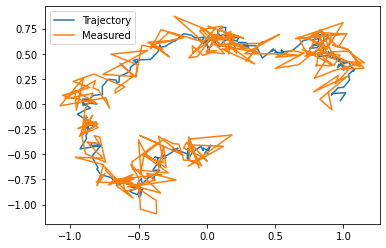

In [19]:
# plot trajectory and noisy measurements

plt.figure()
#fig, ax = plt.subplots()
linetraj = plt.plot(traj[CUT:,0], traj[CUT:,1], label='Trajectory')
linemeas = plt.plot(meas[CUT:,0], meas[CUT:,1], label='Measured')
# linepure = plt.plot(pure_poses[CUT:,0], pure_poses[CUT:,1], label='Pure Poses')
plt.legend()
plt.show()

## 1. Kalman Filtering using known A, B to estimate $\mathbb{E}[X_t | y_1, y_2, ... y_n]$

### 1a. Recalculating gains at each timestep until convergence

Converged in 18 iterations


<Figure size 432x288 with 0 Axes>

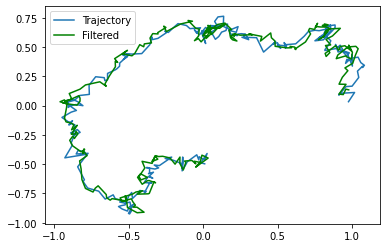

Sum of Squared Error 0.9512924223182231


In [20]:
kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
fltr = kinematics_forward.simulate(meas, u_seq)

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
linefltr, = ax.plot(fltr[CUT:,0], fltr[CUT:,1], label="Filtered", color='g')
plt.legend()
plt.show()

err_fltr = np.linalg.norm(fltr[CUT:,:] - traj[CUT:,:])**2
print("Sum of Squared Error", err_fltr)

### 1b. Kalman Filter with pure steady state gains

Converged in 0 iterations


<Figure size 432x288 with 0 Axes>

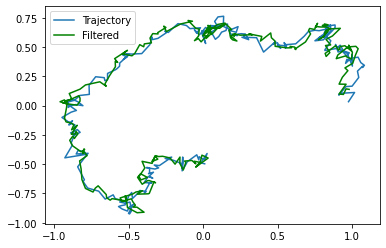

Sum of Squared Error 0.9519932477409503


In [21]:
kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
kinematics_forward.run_till_ss()
fltr_ss = kinematics_forward.simulate(meas, u_seq)

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
#linemeas, = ax.plot(meas[:,0], meas[:,1], label="Measured")
linefltr, = ax.plot(fltr_ss[CUT:,0], fltr_ss[CUT:,1], label="Filtered", color='g')
plt.legend()
plt.show()

err_fltr_ss = np.linalg.norm(fltr_ss[CUT:,:] - traj[CUT:,:])**2
print("Sum of Squared Error", err_fltr_ss)

## 2. Least Squares System ID + Kalman Filtering

###  2a.i. Update on the identified system at each timestep

In [7]:
# Use the same data as before, but now no peeking on what are the actual A, B matrices
A_unk, B_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim))
kinematics = KFilter(A_unk, B_unk, C, Q, R, state=x0)
id_fltr = np.zeros(shape=(T,state_dim))
for t in range(T):
    A_found, B_found = system_id(meas, t, x0, u_seq)
    
    kinematics.A = A_found
    kinematics.B = B_found
    kinematics.predict(u_seq[t])
    kinematics.update(meas[t])
    id_fltr[t] = kinematics.state

<Figure size 432x288 with 0 Axes>

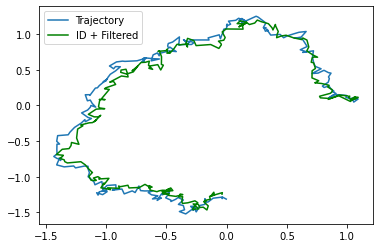

Sum of Squared Error 2.9554029137833764


In [8]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
#linemeas, = ax.plot(meas[:,0], meas[:,1], label="Measured")
linefltr, = ax.plot(id_fltr[CUT:,0], id_fltr[CUT:,1], label="ID + Filtered", color='g')
plt.legend()
plt.show()

err_id_fltr = np.linalg.norm(id_fltr[CUT:,:] - traj[CUT:,:])**2
print("Sum of Squared Error", err_id_fltr)

# 2a.ii. Kalman filter for each timestep simulated from the start

In [23]:
id_fltr_sim = np.zeros(shape=(T,state_dim))
for t in range(1, T):
    A_found, B_found = system_id(meas, t, x0, u_seq)
    kinematics = KFilter(A_found, B_found, C, Q, R, x0)
    id_fltr_sim[t] = kinematics.simulate(meas[:t], u_seq[:t])[-1]

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
C

<Figure size 432x288 with 0 Axes>

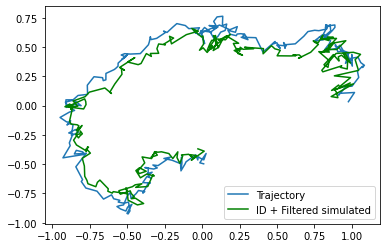

Sum of Squared Error 3.3469058864907004


In [24]:
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory") # cut out first point since it starts at the origin
#linemeas, = ax.plot(meas[CUT:,0], meas[CUT:,1], label="Measured")
linefltr, = ax.plot(id_fltr_sim[CUT:,0], id_fltr_sim[CUT:,1], label="ID + Filtered simulated", color='g')
plt.legend()
plt.show()

err_fltr_sim = np.linalg.norm(id_fltr_sim[CUT:, :] - traj[CUT:, :])**2
print("Sum of Squared Error", err_fltr_sim)

## 3. Learning a Kalman Filter at each timestep: A and B are unknown

Nonlinear system ID of the Kalman Filter parameters:
$$\tilde{x}_{t+1} = A(I - KC)\tilde{x}_t + B u_t + AKy_t$$
$$\tilde{x}_{t+1} = A'\tilde{x}_t + B' u_t + G'y_t $$ 

where $A' = A(I - KC)$, $B' = B$, $G'= AK$

Observations
$$y_t = C' x_t$$ 
(Just use the identity for now, later can try to learn C' as well)

In [31]:
kinematics = LearnedKFilter(state_dim, input_dim, obs_dim, x0)
kinematics.fit(meas, u_seq, eps=3.0, maxIt=20000)
learned_kf_sim = kinematics.simulate(meas, u_seq)

Iteration 10 : Loss 50.15389002560094
Iteration 20 : Loss 32.73930763302675
Iteration 30 : Loss 15.461695332153628
Iteration 40 : Loss 8.110004215866567
Iteration 50 : Loss 6.261410331704492
Iteration 60 : Loss 5.549941220091163
Iteration 70 : Loss 5.483226426845519
Iteration 80 : Loss 5.463862430873554
Iteration 90 : Loss 5.433645805409044
Iteration 100 : Loss 5.412260032782177
Iteration 110 : Loss 5.390406082565212
Iteration 120 : Loss 5.371531106053313
Iteration 130 : Loss 5.354056725274843
Iteration 140 : Loss 5.3365915244341275
Iteration 150 : Loss 5.318976339681702
Iteration 160 : Loss 5.30123297057532
Iteration 170 : Loss 5.283387874330123
Iteration 180 : Loss 5.265486464735622
Iteration 190 : Loss 5.247557628434988
Iteration 200 : Loss 5.229626975960309
Iteration 210 : Loss 5.211719831534889
Iteration 220 : Loss 5.193859210197079
Iteration 230 : Loss 5.1760655643054045
Iteration 240 : Loss 5.158357050670741
Iteration 250 : Loss 5.140749869572303
Iteration 260 : Loss 5.123258448

Iteration 2090 : Loss 3.9612328847197777
Iteration 2100 : Loss 3.959033097118387
Iteration 2110 : Loss 3.956839930762808
Iteration 2120 : Loss 3.954653235996932
Iteration 2130 : Loss 3.9524728670158265
Iteration 2140 : Loss 3.950298681787415
Iteration 2150 : Loss 3.9481305419760933
Iteration 2160 : Loss 3.945968312868279
Iteration 2170 : Loss 3.9438118632997616
Iteration 2180 : Loss 3.9416610655849147
Iteration 2190 : Loss 3.939515795447503
Iteration 2200 : Loss 3.93737593195323
Iteration 2210 : Loss 3.9352413574438594
Iteration 2220 : Loss 3.9331119574728293
Iteration 2230 : Loss 3.930987620742375
Iteration 2240 : Loss 3.9288682390420497
Iteration 2250 : Loss 3.926753707188621
Iteration 2260 : Loss 3.924643922967273
Iteration 2270 : Loss 3.9225387870740493
Iteration 2280 : Loss 3.920438203059562
Iteration 2290 : Loss 3.9183420772737882
Iteration 2300 : Loss 3.9162503188120255
Iteration 2310 : Loss 3.9141628394619365
Iteration 2320 : Loss 3.912079553651567
Iteration 2330 : Loss 3.91000

Iteration 4120 : Loss 3.581680087007873
Iteration 4130 : Loss 3.580084965608238
Iteration 4140 : Loss 3.5784925173206994
Iteration 4150 : Loss 3.5769027374835165
Iteration 4160 : Loss 3.5753156213841564
Iteration 4170 : Loss 3.5737311642626985
Iteration 4180 : Loss 3.5721493613152653
Iteration 4190 : Loss 3.5705702076973975
Iteration 4200 : Loss 3.5689936985273736
Iteration 4210 : Loss 3.5674198288895753
Iteration 4220 : Loss 3.565848593837772
Iteration 4230 : Loss 3.5642799883983907
Iteration 4240 : Loss 3.5627140075737485
Iteration 4250 : Loss 3.561150646345284
Iteration 4260 : Loss 3.5595898996767175
Iteration 4270 : Loss 3.558031762517223
Iteration 4280 : Loss 3.5564762298045154
Iteration 4290 : Loss 3.5549232964679573
Iteration 4300 : Loss 3.553372957431626
Iteration 4310 : Loss 3.551825207617293
Iteration 4320 : Loss 3.550280041947435
Iteration 4330 : Loss 3.548737455348192
Iteration 4340 : Loss 3.5471974427522723
Iteration 4350 : Loss 3.545659999101836
Iteration 4360 : Loss 3.54

Iteration 6150 : Loss 3.3091949944367274
Iteration 6160 : Loss 3.3081214238974583
Iteration 6170 : Loss 3.307050909014951
Iteration 6180 : Loss 3.3059834572750146
Iteration 6190 : Loss 3.304919076095206
Iteration 6200 : Loss 3.303857772822522
Iteration 6210 : Loss 3.302799554731122
Iteration 6220 : Loss 3.301744429020081
Iteration 6230 : Loss 3.300692402811184
Iteration 6240 : Loss 3.299643483146748
Iteration 6250 : Loss 3.298597676987484
Iteration 6260 : Loss 3.297554991210369
Iteration 6270 : Loss 3.2965154326066157
Iteration 6280 : Loss 3.2954790078796057
Iteration 6290 : Loss 3.2944457236429403
Iteration 6300 : Loss 3.293415586418446
Iteration 6310 : Loss 3.2923886026342926
Iteration 6320 : Loss 3.291364778623119
Iteration 6330 : Loss 3.290344120620197
Iteration 6340 : Loss 3.289326634761643
Iteration 6350 : Loss 3.2883123270826937
Iteration 6360 : Loss 3.2873012035159754
Iteration 6370 : Loss 3.2862932698898852
Iteration 6380 : Loss 3.285288531926938
Iteration 6390 : Loss 3.284286

Iteration 8180 : Loss 3.156774959369657
Iteration 8190 : Loss 3.156328349946645
Iteration 8200 : Loss 3.1558842569277257
Iteration 8210 : Loss 3.155442671802283
Iteration 8220 : Loss 3.155003586059532
Iteration 8230 : Loss 3.154566991188963
Iteration 8240 : Loss 3.1541328786807656
Iteration 8250 : Loss 3.153701240026246
Iteration 8260 : Loss 3.1532720667182446
Iteration 8270 : Loss 3.1528453502515283
Iteration 8280 : Loss 3.1524210821231597
Iteration 8290 : Loss 3.1519992538329107
Iteration 8300 : Loss 3.151579856883604
Iteration 8310 : Loss 3.15116288278148
Iteration 8320 : Loss 3.150748323036556
Iteration 8330 : Loss 3.150336169162952
Iteration 8340 : Loss 3.14992641267923
Iteration 8350 : Loss 3.1495190451087187
Iteration 8360 : Loss 3.149114057979827
Iteration 8370 : Loss 3.1487114428263387
Iteration 8380 : Loss 3.1483111911877355
Iteration 8390 : Loss 3.147913294609443
Iteration 8400 : Loss 3.147517744643159
Iteration 8410 : Loss 3.1471245328470863
Iteration 8420 : Loss 3.14673365

Iteration 10200 : Loss 3.1066702071930834
Iteration 10210 : Loss 3.106571040799624
Iteration 10220 : Loss 3.1064728665761683
Iteration 10230 : Loss 3.10637567814346
Iteration 10240 : Loss 3.1062794691353446
Iteration 10250 : Loss 3.1061842331988
Iteration 10260 : Loss 3.1060899639940467
Iteration 10270 : Loss 3.105996655194599
Iteration 10280 : Loss 3.105904300487352
Iteration 10290 : Loss 3.1058128935726588
Iteration 10300 : Loss 3.105722428164405
Iteration 10310 : Loss 3.1056328979900822
Iteration 10320 : Loss 3.1055442967908773
Iteration 10330 : Loss 3.1054566183217545
Iteration 10340 : Loss 3.105369856351524
Iteration 10350 : Loss 3.105284004662937
Iteration 10360 : Loss 3.1051990570527708
Iteration 10370 : Loss 3.105115007331901
Iteration 10380 : Loss 3.105031849325394
Iteration 10390 : Loss 3.1049495768726048
Iteration 10400 : Loss 3.1048681838272456
Iteration 10410 : Loss 3.104787664057486
Iteration 10420 : Loss 3.1047080114460353
Iteration 10430 : Loss 3.104629219890244
Iterati

Iteration 12180 : Loss 3.0992985068967167
Iteration 12190 : Loss 3.0992940249590366
Iteration 12200 : Loss 3.0992896498672726
Iteration 12210 : Loss 3.099285379606599
Iteration 12220 : Loss 3.099281212187896
Iteration 12230 : Loss 3.0992771456476533
Iteration 12240 : Loss 3.0992731780478704
Iteration 12250 : Loss 3.0992693074759625
Iteration 12260 : Loss 3.0992655320446243
Iteration 12270 : Loss 3.0992618498917466
Iteration 12280 : Loss 3.099258259180278
Iteration 12290 : Loss 3.099254758098122
Iteration 12300 : Loss 3.0992513448580143
Iteration 12310 : Loss 3.099248017697406
Iteration 12320 : Loss 3.099244774878307
Iteration 12330 : Loss 3.0992416146872115
Iteration 12340 : Loss 3.099238535434907
Iteration 12350 : Loss 3.0992355354563976
Iteration 12360 : Loss 3.099232613110723
Iteration 12370 : Loss 3.099229766780834
Iteration 12380 : Loss 3.099226994873469
Iteration 12390 : Loss 3.099224295818983
Iteration 12400 : Loss 3.09922166807122
Iteration 12410 : Loss 3.0992191101073576
Itera

KeyboardInterrupt: 

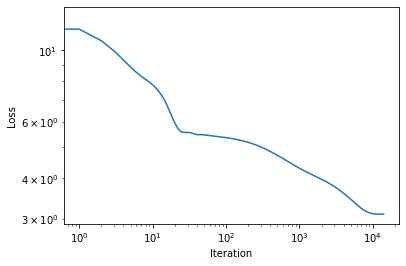

In [32]:
plt.figure()
plt.plot(kinematics.losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale("log")
plt.show()

<Figure size 432x288 with 0 Axes>

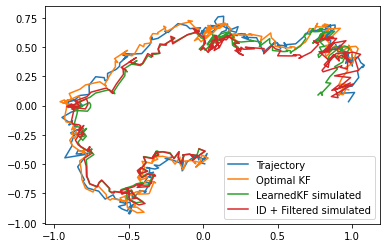

Error between traj and meas 4.4772444474114055
Error between optimal_kf and traj 0.9696004256031979
Error between learned_kf_sim and traj 3.5074063069192154
Error between id_fltr_sim and traj 4.373636592352697


In [30]:
learned_kf_sim = kinematics.simulate(meas, u_seq)

plt.figure()
fig, ax = plt.subplots()

linetraj, = ax.plot(traj[CUT:,0], traj[CUT:,1], label="Trajectory")
linetrueKF, = ax.plot(fltr[CUT:,0], fltr[CUT:,1], label="Optimal KF")
linefltr, = ax.plot(learned_kf_sim[CUT:,0], learned_kf_sim[CUT:,1], label="LearnedKF simulated")
lineopt, = ax.plot(id_fltr_sim[CUT:,0], id_fltr_sim[CUT:,1], label="ID + Filtered simulated")
plt.legend()
plt.show()

print('Error between traj and meas', np.linalg.norm(traj - meas)**2)
print('Error between optimal_kf and traj', np.linalg.norm(traj - fltr)**2)
print('Error between learned_kf_sim and traj', np.linalg.norm(learned_kf_sim - traj)**2)
print('Error between id_fltr_sim and traj', np.linalg.norm(id_fltr_sim - traj)**2)

In [ ]:
print("Aprime", kinematics.Aprime)
print("Aprime true", A @ (np.eye(state_dim) - kinematics_forward.K @ C))
print("Bprime", kinematics.Bprime)
print("Bprime true", B)
print("Gprime", kinematics.Gprime)
print("Gprime true", A @ kinematics_forward.K)